## Project 2: Web Scraping Concert Data

For project #2, I decided

### Songkick.com

![alt text](songkick.png "Songkick Website")


## Web Scraping

![alt text](scrapylogo.png "Scrapy!")

## Data Cleaning

![alt text](cleaneddata.png "Cleaned Data")

# EDA

In [14]:
import spotipy
import spotipy.util as util
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [10]:
concerts = pd.read_csv("concerts_clean.csv", index_col=0)
concerts['date'] = pd.to_datetime(concerts['date'], format = "%Y/%m/%d")

In [11]:
concerts.head()

,date,url,venue,artist,location,time
0,2017-02-02,https://www.songkick.com/metro_areas/7644-us-n...,Knitting Factory,Don Giovanni Records Showcase 2017,new-york,NaN
1,2017-02-03,https://www.songkick.com/metro_areas/7644-us-n...,Madison Square Garden,The Lumineers,new-york,NaN
2,2017-02-03,https://www.songkick.com/metro_areas/7644-us-n...,Terminal 5,AFI,new-york,19:00:00-0500
3,2017-02-03,https://www.songkick.com/metro_areas/7644-us-n...,Webster Hall,Keys N Krates (DJ set),new-york,22:00:00-0500
4,2017-02-03,https://www.songkick.com/metro_areas/7644-us-n...,Music Hall of Williamsburg,Bear's Den,new-york,20:00:00-0500


In [12]:
cityview = concerts.groupby('location')

In [16]:
cityview.describe()[0:10]

artist  \
location                                                            
atlanta          count                                        950   
                 unique                                       789   
                 top                                        DJ EU   
                 freq                                          14   
                 first                                        NaN   
                 last                                         NaN   
boston-cambridge count                                        981   
                 unique                                       844   
                 top     Jeremy Lyons: Delta-Silly Music for Kids   
                 freq                                           6   

                                        date           time  \
location                                                      
atlanta          count                   950            682   
                 unique                  142             52   
                 top     2017-02-18 00:00:00  20:00:00-0500   
                 freq                     32             96   
                 first   2017-02-04 00:00:00            NaN   
                 last    2017-11-22 00:00:00            NaN   
boston-cambridge count                   981            772   
                 unique                  148             56   
                 top     2017-02-11 00:00:00  20:00:00-0400   
                 freq                     25            132   

                                                                       url  \
location                                                                     
atlanta          count                                                 950   
                 unique                                                 20   
                 top     https://www.songkick.com/metro_areas/4120-us-a...   
                 freq                                                   50   
                 first                                                 NaN   
                 last                                                  NaN   
boston-cambridge count                                                 981   
                 unique                                                 20   
                 top     https://www.songkick.com/metro_areas/18842-us-...   
                 freq                                                   50   

                                 venue  
location                                
atlanta          count             950  
                 unique            141  
                 top     Eddie's Attic  
                 freq              143  
                 first             NaN  
                 last              NaN  
boston-cambridge count             981  
                 unique            140  
                 top      The Sinclair  
                 freq               71

In [106]:
city_names = list(cityview.count().index)
city_names = ['ATL', 'BOS', 'CHI', 'DAL', 'HOU', 'LA', 'MIA', "NASH", 'NYC', 'PHL', 'WAS']


In [119]:
cityview.count()

,date,url,venue,artist,time
location,,,,,
atlanta,950,950,950,950,682
boston-cambridge,981,981,981,981,772
chicago,1575,1575,1575,1575,1232
dallas-fort-worth,932,932,932,932,746
houston,688,688,688,688,493
los-angeles,2399,2399,2399,2399,1921
miami,280,280,280,280,234
nashville,683,683,683,683,519
new-york,3515,3515,3515,3515,3011


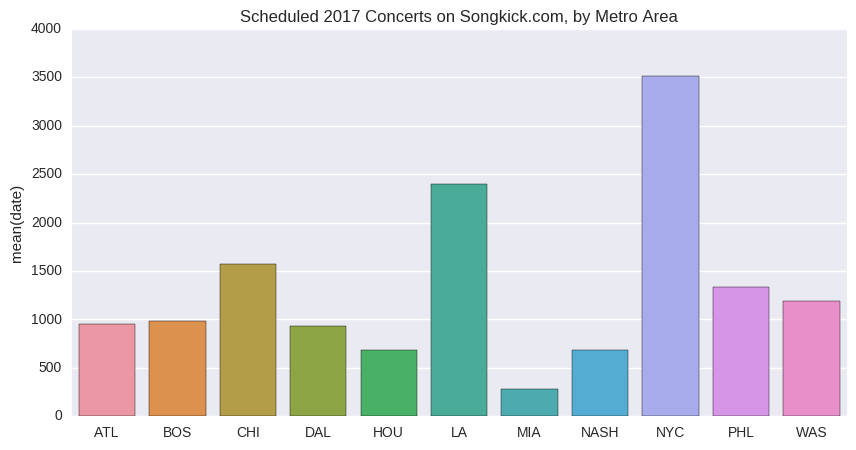

In [123]:
sns.barplot(x=city_names, y=cityview.count()['date'])
sns.plt.title('Scheduled 2017 Concerts on Songkick.com, by Metro Area')

In [141]:
venueview = concerts.groupby('venue')
top_venues = venueview.count().sort_values(by='date', ascending=False)[0:10]

In [160]:
top_venues.index
top_venue_names = ['House of Blues', 'Birdland', "Eddie's Attic",
       "B.B. King's", 'Rockwood Music Hall', 'Jazz Standard', 'Jammin Java',
       'Brooklyn Bowl','The Bowery Electric','Mercury Lounge']

[None, None, None, None, None, None, None, None, None, None]

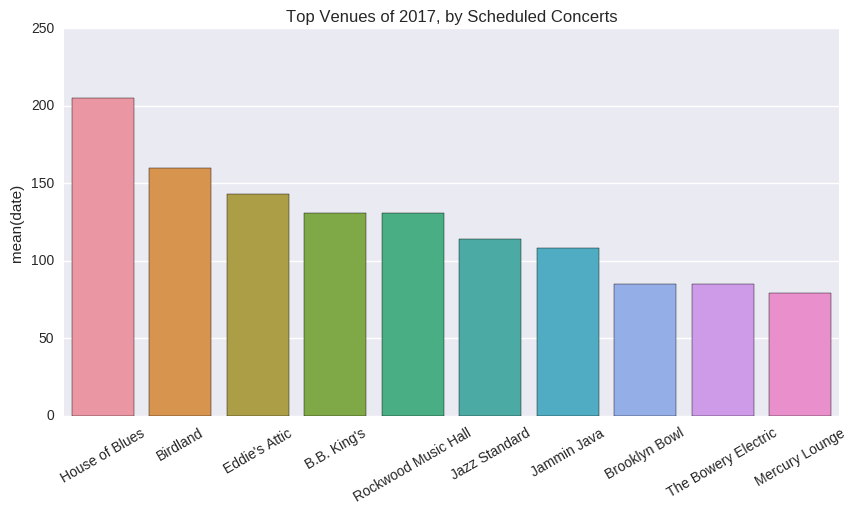

In [161]:
ven = sns.barplot(x=top_venue_names, y=top_venues['date'])
sns.plt.title('Top Venues of 2017, by Scheduled Concerts')
plt.setp(ven.get_xticklabels(), rotation=30)

In [162]:
artists = concerts.groupby('artist')
top_artists = artists.count().sort_values(by='date', ascending=False)[0:10]

In [174]:
top_artists_names = ['B.B. King All Stars', 'DJ Bobby B',
       'Jeffrey Scott Stewart', 'Mingus Big Band',
       'Reverend Vince Anderson',
       'I Love The 90s with \n The Fresh Kids of Bel-Air', 'Rocknoceros',
       'Van Darien', 'Sandra Dean', 'Marcus Terell & the Serenades']

[None, None, None, None, None, None, None, None, None, None]

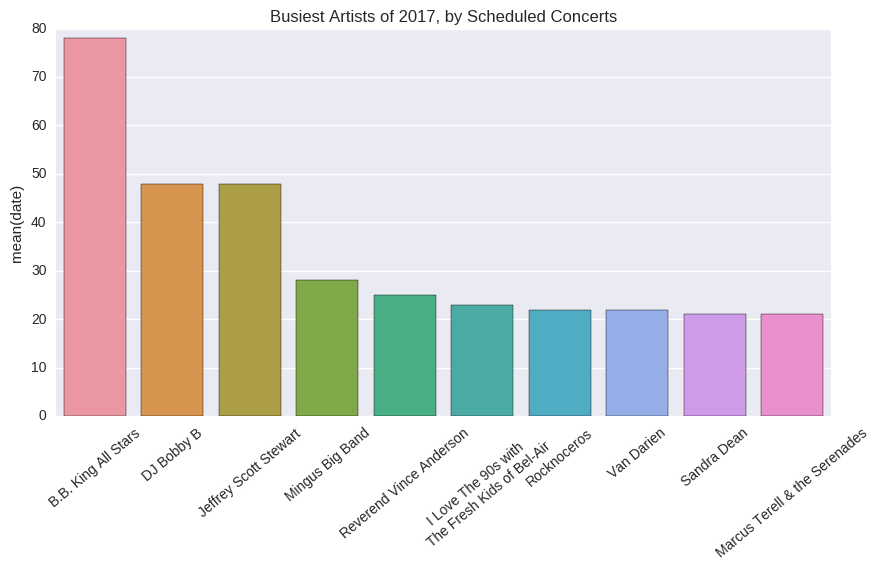

In [178]:
art = sns.barplot(x=top_artists_names, y=top_artists['date'])
sns.plt.title('Busiest Artists of 2017, by Scheduled Concerts')
plt.setp(art.get_xticklabels(), rotation=40)

## Creating a Spotify Playlist

First, use our scraped data to get a list of concerts at a venue over a given time period...

In [190]:
def get_venue_artists(venue, start_date = "2017-01-01", end_date = "2017-12-31"):
    concert_dates = pd.date_range(start = start_date, end = end_date, freq = 'D')
    artists = []
    for show in concerts.loc[concerts['venue'] == venue, ['date', 'artist']].itertuples():
        if show[1] in concert_dates:
            artists.append(show)
    return artists

Use Spotipy library to match artists playing at a venue to Spotify Artist IDs

In [191]:
#NOTE: I would like to add a way to validate the artist returned by the search here. To do later...
def get_artist_ids(artists):
    sp = spotipy.Spotify()
    artist_plus_ids = []
    for artist in artists:
        search = sp.search(q=artist, type = 'artist', limit = 1)
        try:
            artist_plus_ids.append((search['artists']['items'][0]['name'] ,  search['artists']['items'][0]['id']))
        except IndexError:
            pass
    return artist_plus_ids

In [192]:
def get_venue_artist_ids(venue, start_date = "2017-01-01", end_date = "2017-12-31"):
    sp = spotipy.Spotify()
    artists = get_venue_artists(venue, start_date, end_date)
    artist_plus_ids = []
    for artist in artists:
        search = sp.search(q=artist[2], type = 'artist', limit = 1)
        try:
            artist_plus_ids.append((search['artists']['items'][0]['name'] ,  search['artists']['items'][0]['id']))
        except IndexError:
            pass
    return artist_plus_ids


Use Spotipy library to get top tracks from artists, according to Spotify Artist IDs acquired in previous step

In [193]:
def create_venue_songlist(venue, start_date = "2017-01-01", end_date = "2017-12-31"):
    sp = spotipy.Spotify()
    songlist = []
    for artist in get_venue_artist_ids(venue, start_date, end_date):
        artist_tracks = sp.artist_top_tracks(artist[1])['tracks']
        if len(artist_tracks) >= 5:
            for track in range(0, 5):
                songlist.append((artist_tracks[track]['name'], \
                                 artist_tracks[track]['id']))
    return songlist
    

Note: Sets vs Lists

In [194]:
def prepare_song_id_list(songlist):
    song_ids = []
    for song in songlist:
        song_ids.append(str(song[1]))
    return song_ids

In [195]:
def create_venue_songlist_ids(venue, start_date = "2017-01-01", end_date = "2017-12-31"):
    songlist = create_venue_songlist(venue, start_date, end_date)
    print type(songlist)
    if len(songlist) >= 100:
        songlist = songlist[0:99]
    ptitle = ("%s from %s to %s") % (venue, start_date, end_date)
    return (ptitle, prepare_song_id_list(songlist))

#### Now that we have a list of song IDs, let's authenticate a spotify login, and create the playlist

![alt text](spotifywebdev.png "Registering an app was suprisingly easy")

In [196]:
SPOTIPY_CLIENT_ID = '1723f7534a1c4cde9efe16b0b2753d7f'
SPOTIPY_CLIENT_SECRET = 'e3e4b35b367a430c8b2900ef5d6165a7'
SPOTIPY_REDIRECT_URI = 'http://localhost:8888'

In [197]:
token = util.prompt_for_user_token("", 'playlist-modify-public', SPOTIPY_CLIENT_ID, SPOTIPY_CLIENT_SECRET, SPOTIPY_REDIRECT_URI)

In [198]:
username = 'afeierman'
playlist_prepped = create_venue_songlist_ids("Madison Square Garden", '2017-04-01', '2017-05-01')
playlist_title = playlist_prepped[0]
track_ids = playlist_prepped[1]

<type 'list'>


In [201]:
print type(token)
print token

<type 'unicode'>
BQDp9igkdOhAwgtJ4MZNTl8KnVh1HimJAdtBbmHTeBje02qSW2likMZeomEprKSQy2Ia2DQziwsyw4mL-AN1CFjRIedSMudyrvU9Nw_r15pHHQkOZQfq6VSirGdz1_V28VP9eGjaclMOtgEOJEJt7rd2nZBTLlDlImBfBWkyTDG_7zLUjmhOoxsiM3EtkJUgKznCDPbMz0KiMnZ41dRElHb2wOOrSDFujHQ_GHqJLDlnvQ


### If everything works correctly, the code below creates a Spotify playlist

In [200]:
if token:
    sp = spotipy.Spotify(auth=token)
    sp.trace = False #Not sure if this is needed
    sp.user_playlist_create(username, playlist_title)
    playlists = sp.user_playlists(username)
    for playlist in playlists['items']:
        if playlist['name'] == playlist_title:
            playlist_id = playlist['id']
            break
    results = sp.user_playlist_add_tracks(username, playlist_id, track_ids)
    print results
else:
    print "Can't get token"

{u'snapshot_id': u'xUUmw5/sBt2mk/Odv4ye8QILslXb9mNblPSaNRRicqk9p2wmDnRd5NSXflxh8DTt'}


In [205]:
# ![alt text](spottyplaylist.png "Display Spotify Playlist")

![alt text](flask.png "Flask is difficult to learn")


![alt text](jquery-logo.jpg "and Javascript...")

![alt text](pa.png "and PythonAnywhere")